In [1]:
#############################################
## Boston House Prices Regression Analysis ##
#############################################

# The main goal of this analysis is to get a better understanding of the dataset
# and build a model that predicts the house prices

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

In [3]:
# Load data
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
# Convert into data frame
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df["MEDV"] = boston.target

# Since the data is in a json file, the first step is to transform it into a proper dataset

In [5]:
# Define features and dependant variable
X = boston_df[boston_df.columns.difference(["MEDV"])]
y = boston_df["MEDV"]

# Here I define which variables are going to be used as features to build the predictive model
# and which one is going to be the target of said prediction

In [6]:
# Get to know the data
boston_df.describe()

# Here we can see statistical information for each variable, and get a better idea of the dataset

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
# Normalize data sets
X = X.apply(lambda x: ((x - x.min()) / (x.max() - x.min())), axis = 0)

# Since we have many features with different scales and ranges
# I decided to normalize them between 0 and 1 maintaining the distance

In [8]:
# Get to know the data
boston_df.info()

# A simple step justo to verify that each variable has the correct type
# although "CHAS" should be categorical I dedcided to maintain it's numerical properties for the modeling part

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


In [9]:
# "CHAS" value count
boston_df["CHAS"].value_counts().to_frame()

# To get a better grasp about the distribution of the two classes

,CHAS
0.0,471
1.0,35


In [10]:
# Check for missing values
boston_df.isnull().sum().to_frame("Missing Values")

# Rutinary step to see if there is any missing value

,Missing Values
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [11]:
# Check for duplicated rows
print("Duplicated Rows:", boston_df.duplicated().sum())

# Rutinary step to see if there is any duplicated row

Duplicated Rows: 0


In [12]:
# Check feature variance
variance = X.var()
variance.to_frame("Variance")

# Here I get the variance of every feature,
# since all of them are normalized, we can compare the variance between features
# and see which ones have more dispersed valued relative to eachother

,Variance
AGE,0.084039
B,0.052995
CHAS,0.064513
CRIM,0.009347
DIS,0.036665
INDUS,0.063242
LSTAT,0.038828
NOX,0.056850
PTRATIO,0.053044
RAD,0.143320


In [13]:
# Remove "CRIM"
del X["CRIM"]

# I choosed to remove "CRIM" since it has very little variance
# that means that that feature has almost the same value in every row,
# so it's not adding much information

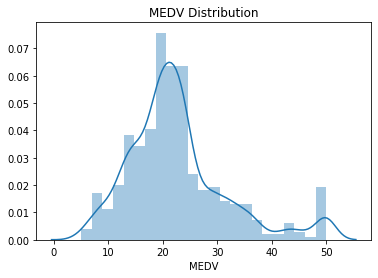

In [14]:
# Check "MEDV" distribution
sn.distplot(boston_df["MEDV"], bins = "auto").set_title("MEDV Distribution")
plt.show()

# Here we can see the distribution of every value in the target variable
# it is centered around 20 and it is close to being normaly distributed
# it has a peak at 50 that might cause problems to the predictive model

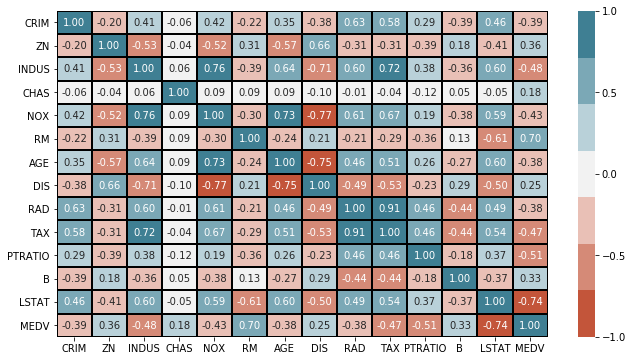

In [15]:
# Correlation matrix
corr = boston_df.corr()
fig, HM = plt.subplots(figsize = (11, 6))
HM = sn.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = sn.diverging_palette(20, 220, n = 7),
                fmt = ".2f", linewidths = 1, linecolor = "black", annot = True,
                cbar_kws = {"ticks" : [-1, -.5, 0, 0.5, 1]})
bottom, top = HM.get_ylim()
HM.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Here we can see how the different variables in the dataset are correlated to eachother
# -1 and 1 meaning a highly negative/positive relation respectively and 0 not related at all

# Here we are looking for 2 things:
# -Features that are highly correlated with the target variable "MEDV"
# and we have two of those: "RM and "LSTAT, these two features are the most important predictors
# -Features that are highly correlated with other features
# we have many of those:
# "INDUS" - "NOX"
# "INDUS" - "DIS"
# "INDUS" - "TAX"
# "NOX" - "DIS"
# "AGE" - "DIS"
# "TAX" - "RAD"
# having these correlations wont be good for the predictive model, and we should break as many as we can

In [16]:
# Remove "TAX" and "DIS"
X = X.drop(["TAX", "DIS"], axis = 1)

# By removing these two features we break all of the already mentioned correlations except one

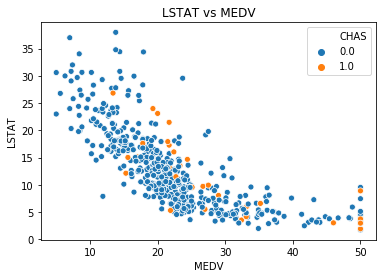

In [17]:
# Plot highly correlated features with "MEDV"
MvL = sn.scatterplot(x = "MEDV", y = "LSTAT", hue = "CHAS", data = boston_df)
MvL.set_title("LSTAT vs MEDV")
plt.show()

# Here we can form a better idea of how "LSTAT" and "MEDV" are related
# "LSTAT" decreases as "MEDV" increases
# also this relation starts weak and get stronger as "MEDV" increases
# also good to keep in mind the "MEDV" value distribution previously shown

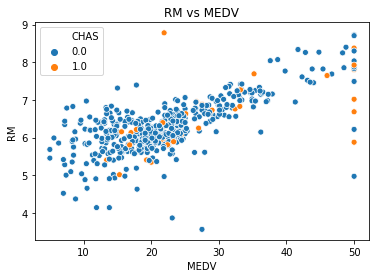

In [18]:
# Plot highly correlated features with "MEDV"
MvR = sn.scatterplot(x = "MEDV", y = "RM", hue = "CHAS", data = boston_df)
MvR.set_title("RM vs MEDV")
plt.show()

# Here we can form a better idea of how "RM" and "MEDV" are related
# "RM" increases as "MEDV" decreases
# also this relation starts weak and get stronger as "MEDV" increases
# also good to keep in mind the "MEDV" value distribution previously shown

In [19]:
# Anova test for "CHAS"
df = boston_df[["MEDV", "CHAS"]]
F, p = stats.f_oneway(df[df.CHAS == 0].MEDV,
                      df[df.CHAS == 1].MEDV)
print("CHAS:", "%f" % p)

# "CHAS" is a categorical feature
# as such you cannot see how it is related to another variable in a correlation matrix
# one aplication of the anova test is to see if there exists a correlation between different types of variables
# if the obtained value its inferior than the 0.05 level of signigicance then the two variables are correlated

CHAS: 0.000074


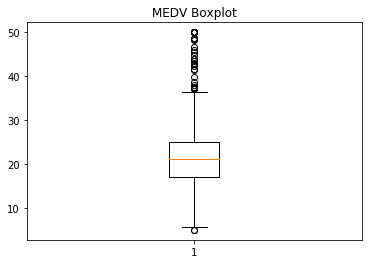

In [20]:
# Check for outliers on "MEDV"
plt.boxplot(boston_df["MEDV"], whis = 1.5)
plt.title("MEDV Boxplot")
plt.show()

# Removing outliers of the target variable can increase the predictive model performance

In [21]:
# "MEDV" outlier values
Q1 = boston_df["MEDV"].quantile(0.25)
Q3 = boston_df["MEDV"].quantile(0.75)
IQR = Q3 - Q1

boston_df[(df["MEDV"] < Q1 - 1.5 * IQR ) | (boston_df["MEDV"] > Q3 + 1.5 * IQR)]["MEDV"].to_frame("MEDV Outliers")

# Here we can see the value of the already mentioned observations
# I opted not to remove them since they seem to be grouped at value 50
# and seem to belong to a category of the price range

,MEDV Outliers
97,38.7
98,43.8
157,41.3
161,50.0
162,50.0
163,50.0
166,50.0
179,37.2
180,39.8
182,37.9


In [22]:
# Define train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# Here I split the dataset 70% to train the model and 30% to test it

In [23]:
# Train shape
X_train.shape, y_train.shape

((354, 10), (354,))

In [24]:
# Test shape
X_test.shape, y_test.shape

((152, 10), (152,))

In [25]:
# Add cross-validation step
kf = KFold(n_splits = 10)

# Since the dataset doesnt have many observations I decided to add this step to get more robust train metrics

In [26]:
# Linear regression for reference
reg0 = LinearRegression()
reg0.fit(X_train, y_train)

# Define and train model on train set

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
# Predictions
y_pred0 = reg0.predict(X_test)

# Use the model to make predictions on test set

In [28]:
# Test error metrics
rmse_0 = (np.sqrt(mean_squared_error(y_test, y_pred0)))
r2_0 = r2_score(y_test, y_pred0)

print("Test Error Metrics", "\n"
      "RMSE:" "\t" "%.3f" % rmse_0, "\n"
      "R^2:" "\t" "%.3f" % r2_0)

# Check model perfomance
# this first model is just to have a reference point
# and see how much better a tuned model performs

Test Error Metrics 
RMSE:	5.691 
R^2:	0.599


In [29]:
# Extreme gradient boosted trees
reg = xgb.XGBRegressor(objective = "reg:squarederror",
                          colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 500,
                          random_state = 123)

reg.fit(X_train.values, y_train.values)

# Define and train model on train set

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [30]:
# Cross-validation error metrics
scores = cross_val_score(reg, X_train.values, y_train.values, cv = kf, scoring = "r2")

print("Train R^2", "\n"
      "Scores:" "\t", list(np.sort(np.around(scores, decimals = 3))), "\n"
      "Range:" "\t", "%.3f" % (scores.max() - scores.min()), "\n"
      "Mean:" "\t", "%.3f" % scores.mean())

# Here we can see the R^2 of each repetition of the cross-validation step
# the range between the max and minimun and its mean
# these are just to evaluate the performance on the train set

Train R^2 
Scores:	 [0.781, 0.801, 0.828, 0.839, 0.863, 0.87, 0.885, 0.914, 0.92, 0.95] 
Range:	 0.169 
Mean:	 0.865


In [31]:
# Predictions
y_pred = reg.predict(X_test.values)

# Use the model to make predictions on the test set

In [32]:
# Test error metrics
errors = y_test - y_pred
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print("Test Error Metrics", "\n"
      "RMSE:" "\t" "%.3f" % rmse, "\n"
      "R^2:" "\t" "%.3f" % r2)

# Here we have the error metrics of the predictions made by the model
# the R^2 its a bit lower than in the train, so it might indicate a bit of overfitting

Test Error Metrics 
RMSE:	4.458 
R^2:	0.754


In [33]:
# Svm
reg1 = SVR(kernel = "rbf", C = 200, gamma = "auto")
reg1.fit(X_train, y_train)

# Define and train model on train set

SVR(C=200, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
# Cross-validation error metrics
scores1 = cross_val_score(reg1, X_train, y_train, cv = kf, scoring = "r2")

print("Train R^2", "\n"
      "Scores:" "\t", list(np.sort(np.around(scores1, decimals = 3))), "\n"
      "Range:" "\t", "%.3f" % (scores1.max() - scores1.min()), "\n"
      "Mean:" "\t", "%.3f" % scores1.mean())

# Here we can see the R^2 of each repetition of the cross-validation step
# the range between the max and minimun and its mean
# these are just to evaluate the performance on the train set

Train R^2 
Scores:	 [0.604, 0.665, 0.802, 0.817, 0.82, 0.852, 0.855, 0.863, 0.893, 0.9] 
Range:	 0.296 
Mean:	 0.807


In [35]:
# Predictions
y_pred1 = reg1.predict(X_test)

# Use the model to make predictions on the test set

In [36]:
# Test error metrics
errors1 = y_test - y_pred1
rmse_1 = (np.sqrt(mean_squared_error(y_test, y_pred1)))
r2_1 = r2_score(y_test, y_pred1)

print("Test Error Metrics", "\n"
      "RMSE:" "\t" "%.3f" % rmse_1, "\n"
      "R^2:" "\t" "%.3f" % r2_1)

# Here we have the error metrics of the predictions made by the model
# the R^2 its a bit lower than in the train, so it might indicate a bit of overfitting

Test Error Metrics 
RMSE:	4.616 
R^2:	0.736


In [37]:
# Summary
print("\t" "\t" "Linear Model", "\n"
      "Test RMSE:" "\t" "%.3f" % rmse_0, "\n"
      "Test R^2:" "\t" "%.3f" % r2_0, "\n", "\n"
      "\t" "\t" "\t" "XGB" "\t" "SVM", "\n"
      "Train R^2 Range:" "\t" "%.3f" % (scores.max() - scores.min()), "\t" "%.3f" % (scores1.max() - scores1.min()), "\n"
      "Train R^2 Mean:" "\t" "\t" "%.3f" % scores.mean(), "\t" "%.3f" % scores1.mean(), "\n"
      "Test RMSE:" "\t" "\t" "%.3f" % rmse, "\t" "%.3f" % rmse_1, "\n"
      "Test R^2:" "\t" "\t" "%.3f" % r2, "\t" "%.3f" % r2_1)

# Here we have the performance of the 2 models so we can compare them and choose one
# the CV R^2 Range of the XGB model is smaller
# that means that every iteration of the cross-validation step gave very similar results
# the XGB model also has a smaller RMSE and a higher R^2
# for now seems that XGB will be the model to go

		Linear Model 
Test RMSE:	5.691 
Test R^2:	0.599 
 
			XGB	SVM 
Train R^2 Range:	0.169 	0.296 
Train R^2 Mean:		0.865 	0.807 
Test RMSE:		4.458 	4.616 
Test R^2:		0.754 	0.736


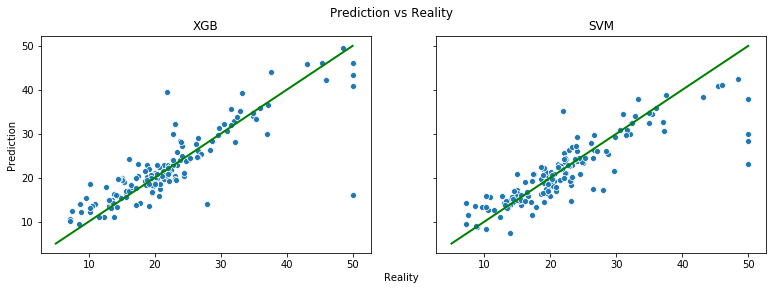

In [38]:
# Comparing Prediction vs Reality
fig, (PvR_XGB, Pvr_SVM) = plt.subplots(ncols = 2, sharey = True, sharex = True, figsize = (13, 4))
sn.scatterplot(x = y_test, y = y_pred, ax = PvR_XGB)
PvR_XGB.set_title("XGB")
PvR_XGB.set_xlabel("")
PvR_XGB.set_ylabel("Prediction")
PvR_XGB.plot([y.min(), y.max()], [y.min(), y.max()], color = "g", lw = 2)
sn.scatterplot(x = y_test, y = y_pred1, ax = Pvr_SVM)
Pvr_SVM.set_title("SVM")
Pvr_SVM.set_xlabel("")
Pvr_SVM.plot([y.min(), y.max()], [y.min(), y.max()], color = "g", lw = 2)
fig.suptitle("Prediction vs Reality")
fig.text(0.51, 0.03, "Reality", ha = "center")
plt.show()

# Here we can see the errors of the 2 models
# XGB have a small number of big errors spread across
# but in general the rest of the predictions are very good and stable
# SVM have a concentration of big errors at the 50 value
# the rest of the predictions are slightly worse than the XGB ones

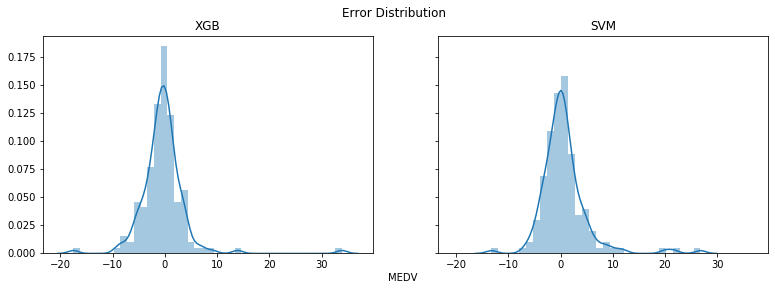

In [39]:
# Error distribution
fig, (Distr_XGB, Distr_SVM) = plt.subplots(ncols = 2, sharey = True, sharex = True, figsize = (13, 4))
sn.distplot(errors, bins = "auto", ax = Distr_XGB)
Distr_XGB.set_title("XGB")
Distr_XGB.set_xlabel("")
sn.distplot(errors1, bins = "auto", ax = Distr_SVM)
Distr_SVM.set_title("SVM")
Distr_SVM.set_xlabel("")
fig.suptitle("Error Distribution")
fig.text(0.51, 0.03, "MEDV", ha = "center")
plt.show()

# Here we can see how the errors previously shown are distributed
# both are normaly distributed and thats a good thing
# XGB has the distribution more pronounced around 0
# that means that the model makes mostly good predictions or small errors

In [40]:
# Final model
# based on the observations made above I will choose the XGB model
# and for a better understanding of the model im going to look further into its errors

In [48]:
# Add "MEDV" to test
X_test.loc[:, "MEDV"] = list(y_test)

In [42]:
# Add XGB predictions to test
X_test.loc[:, "Predictions"] = list(y_pred)

In [43]:
# Add XGB errors to test
errors = errors.abs()
X_test.loc[:, "Errors"] = list(errors)

In [49]:
# Add column color code errors higher than 8
X_test.loc[:, "Color"] = list(X_test.apply(lambda x: "Red" if (x["Errors"] > 8) else "Green", axis = 1))

X_test["Color"].value_counts()

# This column will label each observation with either "Red" if the error made is higher than 8
# or "Green" if the error made was lower than 8 counting itself
# we can see that the model made 7 erros greater than 8

Green    145
Red        7
Name: Color, dtype: int64

In [45]:
# Rows with high errors
X_test[X_test["Color"] == "Red"]

# Here we can see the rows of the test set where the model made a big error

,AGE,B,CHAS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,ZN,MEDV,Predictions,Errors,Color
364,0.823893,0.893212,1.0,0.646628,0.098234,0.685185,0.808511,1.000000,1.000000,0.0,21.9,39.405430,17.505430,Red
372,0.892894,0.876393,1.0,0.646628,0.197296,0.582305,0.808511,1.000000,0.443380,0.0,50.0,16.096506,33.903494,Red
407,1.000000,0.836578,0.0,0.646628,0.286976,0.563786,0.808511,1.000000,0.392221,0.0,27.9,13.957350,13.942650,Red
367,1.000000,0.330576,0.0,0.646628,0.320088,0.506173,0.808511,1.000000,0.057865,0.0,23.1,32.267876,9.167876,Red
370,0.974253,0.987770,1.0,0.646628,0.033940,0.506173,0.808511,1.000000,0.662004,0.0,50.0,40.929382,9.070618,Red
310,0.359423,0.882874,0.0,0.346041,0.301049,0.327160,0.617021,0.130435,0.270550,0.0,16.1,24.191391,8.091391,Red
426,0.584964,0.061350,0.0,0.646628,0.385210,0.409465,0.808511,1.000000,0.436099,0.0,10.2,18.656027,8.456027,Red


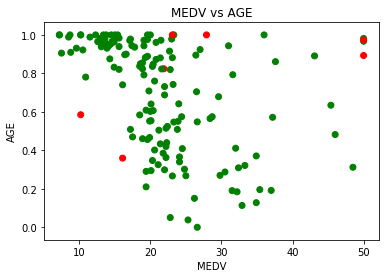

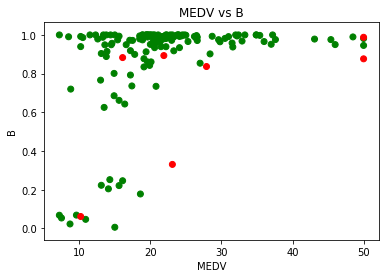

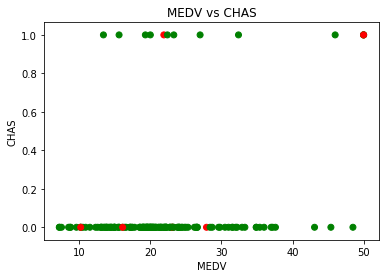

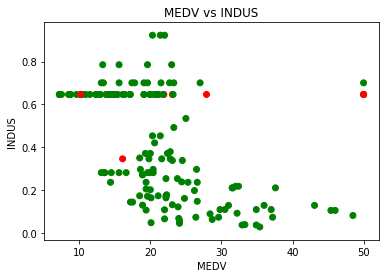

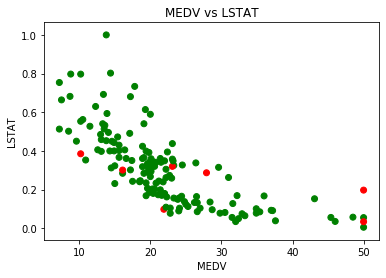

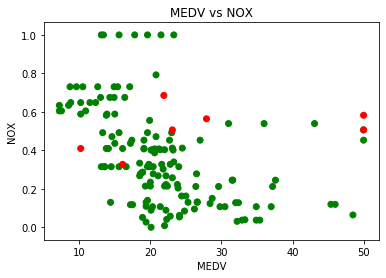

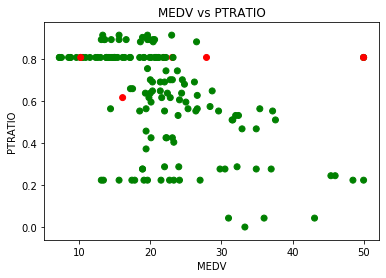

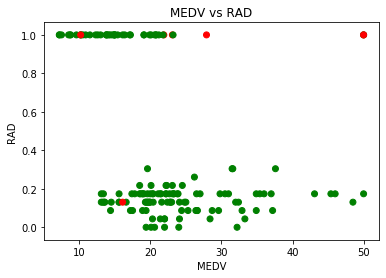

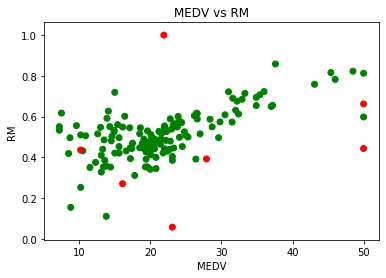

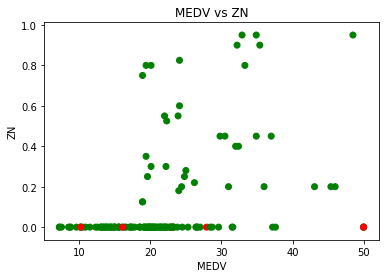

In [46]:
# Plot "MEDV" vs features colored by error class
x_col = "MEDV"
y_columns = list(X_test[X_test.columns.difference(["MEDV", "Color", "Predictions", "Errors"])])

for y_col in y_columns:
    figure = plt.figure
    ax = plt.gca()
    ax.scatter(X_test[x_col], X_test[y_col], c = X_test["Color"])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))
    plt.show()
    
# And here a scatter plot of every feature vs "MEDV" colored by the error type
# based on the error exploration we can say that they have nothing in common
# the big errors are well spread and are not easily explained by any feature

In [47]:
# What we have learned
# the two things that influence price the most are
# the average number of rooms per dwelling and the percentage of lower status of the population
# the price distribution is centered around 19-21 and then it decreases untill 5 for one extreme
# and 49 for the other extreme, with a small group of outliers at 50

# the predictive model performs notably well, but should be improved for a practical application
# the RMSE of 4.458 is a bit high compared to the price man of 22.532
# the R^2 of 0.754 is also a bit low, for a trustworthy model it should be around 0.9
# the error distribution is quite good, centered at 0 and rapidly decreasing with only a few big errors
# the errors doesnt seem to follow any pattern